In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

In [74]:
# load dataset
data = load('/content/drive/MyDrive/data/image-recogination/faces-embeddings7.npz',allow_pickle=True)
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=55, test=46


In [75]:
import numpy as np
trainX = np.concatenate([trainX,testX])
trainy = np.concatenate([trainy,testy])

In [5]:
trainX

array([[-0.51281977, -2.0844905 , -0.27997577, ...,  0.13550013,
         0.6360367 ,  0.16756709],
       [-0.10919723, -1.917176  , -0.05704866, ...,  0.2957483 ,
         0.4212744 , -0.07727769],
       [-0.11069912, -1.7231795 , -0.6798145 , ...,  0.11300723,
         0.8462457 , -0.13662094],
       ...,
       [ 1.6442227 , -1.0150325 ,  0.2720818 , ..., -0.04111984,
        -0.62958384, -0.660256  ],
       [ 1.7943672 , -1.0582769 ,  0.4317607 , ..., -0.20199654,
        -0.84391546, -0.06798676],
       [ 1.6262637 , -0.8243176 ,  0.27831188, ...,  0.20632976,
        -0.6444143 , -0.973744  ]], dtype=float32)

In [ ]:
np.any(np.isnan(trainX))
np.all(np.isfinite(trainX))
np.any(np.isnan(testX))
np.all(np.isfinite(testX))

False

In [ ]:
import numpy.ma as ma

In [ ]:
trainX = np.where(np.isnan(trainX), ma.array(trainX, mask=np.isnan(trainX)).mean(axis=0), trainX)   
testX = np.where(np.isnan(testX), ma.array(testX, mask=np.isnan(testX)).mean(axis=0), testX)    

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [76]:
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [77]:
print(trainX.shape,testX.shape)

(101, 128) (46, 128)


In [78]:
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [ ]:
print(trainy)

[0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4
 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 4 4 4 4 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5]


In [66]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [67]:
svc = SVC(kernel='sigmoid', probability=True)
model2 = BaggingClassifier(base_estimator=svc,n_estimators=15, random_state=2)
model2.fit(trainX,trainy)

BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='sigmoid',
                                     max_iter=-1, probability=True,
                                     random_state=None, shrinking=True,
                                     tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=15, n_jobs=None,
                  oob_score=False, random_state=2, verbose=0, warm_start=False)

In [38]:
# predict
yhat_train = model2.predict(trainX)
yhat_test = model2.predict(testX)

In [39]:
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)

In [40]:
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [13]:
# load faces
data = load('/content/drive/MyDrive/data/image-recogination/faces-dataset10.npz',allow_pickle=True)
testX_faces = data['arr_2']

In [49]:
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [70]:
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model2.predict(samples)
yhat_prob = model2.predict_proba(samples)

In [71]:
print(yhat_class,yhat_prob)

[3] [[0.00211929 0.01828404 0.00570672 0.95717816 0.00280598 0.0139058 ]]


In [56]:
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

Predicted: Manan (97.557)
Expected: Manan


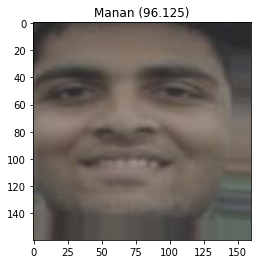

In [53]:
# plot for fun
pyplot.imshow(np.array(random_face_pixels).astype(np.uint8))
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

In [58]:
import pickle

In [73]:
pickling_on = open("/content/drive/MyDrive/data/image-recogination/face_model16.pickle","wb")
pickle.dump(model2, pickling_on)
pickling_on.close()

In [ ]:
pickling_on = open("/content/drive/MyDrive/data/image-recogination/LabelEncoder.pickle","wb")
pickle.dump(out_encoder, pickling_on)
pickling_on.close()

In [ ]:
import tensorflow
tensorflow.__version__

'2.6.0'

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'